In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img

In [21]:
# train_dir = '/home/atif/machine_learning_stuff/ml_image/copy_image/train'
# validation_dir = '/home/atif/machine_learning_stuff/ml_image/copy_image/validation'

train_dir = '/home/atif/machine_learning_stuff/ml_image/train_image_AI'
validation_dir = '/home/atif/machine_learning_stuff/ml_image/validation_image_AI'
image_size = 224
NUM_CLASS = 16

# All layers are freezed. Same as pre trained weights

In [22]:
from keras.applications import VGG16

#Load the VGG model
# vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
vgg_conv = VGG16(weights='/home/atif/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASS, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

<keras.engine.topology.InputLayer object at 0x7f0791d0dc18> False
<keras.layers.convolutional.Conv2D object at 0x7f0791d0de10> False
<keras.layers.convolutional.Conv2D object at 0x7f072414c2e8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0791824080> False
<keras.layers.convolutional.Conv2D object at 0x7f079180ceb8> False
<keras.layers.convolutional.Conv2D object at 0x7f07917fb390> False
<keras.layers.pooling.MaxPooling2D object at 0x7f07917aaa90> False
<keras.layers.convolutional.Conv2D object at 0x7f0791752198> False
<keras.layers.convolutional.Conv2D object at 0x7f0791752b38> False
<keras.layers.convolutional.Conv2D object at 0x7f0791765ef0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0791708fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f07917360f0> False
<keras.layers.convolutional.Conv2D object at 0x7f0791736400> False
<keras.layers.convolutional.Conv2D object at 0x7f07916c6f98> False
<keras.layers.pooling.MaxPooling2D object at 0x7f07916e9908> Fa

# Training. No image augmentation

In [23]:
epoch = 2
saved_model_path = '/home/atif/machine_learning_stuff/unreal_cv_image/unreal_cv_image_manipulation/classification_UE4_image/trained_model/'

Found 57600 images belonging to 16 classes.
Found 48 images belonging to 16 classes.
Epoch 1/2
576/576 [==============================] - 257s 447ms/step - loss: 0.1918 - acc: 0.9494 - val_loss: 1.0164e-04 - val_acc: 1.0000
Epoch 2/2
576/576 [==============================] - 258s 448ms/step - loss: 0.0054 - acc: 0.9988 - val_loss: 2.6909e-06 - val_acc: 1.0000


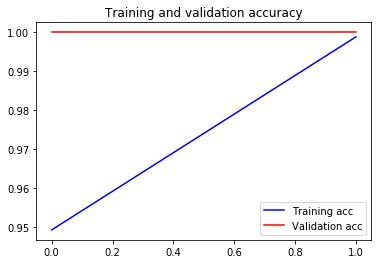

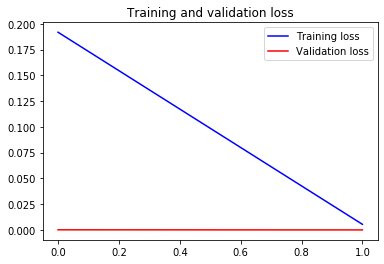

In [24]:
# No Data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=epoch,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the Model
model.save(saved_model_path+'all_freezed_old.h5')

# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
from keras.models import load_model
# model = load_model('/home/atif/machine_learning_stuff/model_file_keras/general_2_sep_ep_30_epoch.h5')
model = load_model(saved_model_path+'all_freezed_old.h5')

In [37]:
model

In [38]:
import pandas as pd
import numpy as np
from skimage import io, color, exposure, transform
from skimage.color import rgb2gray
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split  #it came from update scikit learn. https://stackoverflow.com/questions/40704484/importerror-no-module-named-model-selection
import os
import glob
import h5py
import keras
IMG_SIZE = 224


def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,centre[1]-min_side//2:centre[1]+min_side//2,:]
#    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
#     img = np.rollaxis(img,-1) # comment out it if want to use channel last

    return img

def get_class(img_path):
    return int(img_path.split('/')[-2])
#     return str(img_path.split('/')[-2]) # returning the folder name. If use -1 that means image name. consider the img_path.


test = pd.read_csv('/home/atif/machine_learning_stuff/ml_image/test_image_keras_IAI.csv',sep=';')
# test_image_path =  '/home/atif/machine_learning_stuff/ml_image/test_image_crop/'

X_test = []
y_test = []
i = 0
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    print('filename: ',file_name,'\t classId: ',class_id)
    #print('classId: ',class_id)
    img_path = os.path.join('/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/',file_name)
#     img_path = glob.glob(os.path.join(test_image_path, '*/*.jpg'))
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

filename:  denkmit_edelstahk_reiniger (1).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (2).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (3).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (4).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (5).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (6).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (7).jpg 	 classId:  5
filename:  denkmit_Entkalker (1).jpg 	 classId:  7
filename:  denkmit_Entkalker (2).jpg 	 classId:  7
filename:  denkmit_Entkalker (3).jpg 	 classId:  7
filename:  denkmit_Entkalker (4).jpg 	 classId:  7
filename:  denkmit_Entkalker (5).jpg 	 classId:  7
filename:  denkmit_Entkalker (6).jpg 	 classId:  7
filename:  denkmit_geschirrreiniger_REVOLUTION (1).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (2).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (3).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (4).jpg 	 classId

In [39]:
X_test.shape

(89, 224, 224, 3)

In [40]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.07865168539325842


In [42]:
import glob

test_image_path = r'/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/'

my_name = ['SM_CalgonitFinish_2','SM_CalgonitFinishKlarspueler_5','SM_CalgonitFinishMaschinenpfleger_8','SM_CalgonitFinishSpezialSalz_11',
           'SM_CalgonitFinishVorratspack_14','SM_DenkMitEdelstahlreiniger_17','SM_DenkMitEdelstahlReinigerSpray_20','SM_DenkMitEntkalker_23',
           'SM_DenkMitGeschirrReiniger_26','SM_DenkMitGeschirrReinigerClassic_29','SM_DenkMitGeschirrReinigerEvo_32','SM_DenkMitGeschirrReinigerNature_35',
           'SM_DenkMitHygieneAllzweckreiniger_38','SM_DenkMitMaschinenpfleger_41','SM_DenkMitSpezialsalz_44','SM_SomatClassic_53']

img_path = glob.glob(test_image_path+ '/*.jpg')
for image in img_path:
    X_test=[]
    X_test.append(preprocess_img(io.imread(image)))
    X_test = np.array(X_test)
#     plt.imshow(X_test)
    X_test = X_test.reshape(len(X_test),IMG_SIZE,IMG_SIZE,3)
    
    print('image name is: ',image)
    predicted_class = model.predict_classes(X_test)
    print("predicted class: ",predicted_class)
#     print('type-of predicted calss: ', type(predicted_class))
    print('class name is: ',my_name[predicted_class[0]])
    
#     probability = model.predict_proba(X_test)
#     print("probability: ",probability)
    print('\n')

image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_hygiene_Allzweck_reiniger (4).jpg
predicted class:  [4]
class name is:  SM_CalgonitFinishVorratspack_14


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_edelstahk_reiniger (2).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/calgonit_finish_speizalsalz (3).jpg
predicted class:  [9]
class name is:  SM_DenkMitGeschirrReinigerClassic_29


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_edelstahk_reiniger (5).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_edelstahk_reiniger (3).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/te

image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_spezalsalz (3).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/calgonit_maschine_pfleger (2).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_spezalsalz (1).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_spezalsalz (8).jpg
predicted class:  [10]
class name is:  SM_DenkMitGeschirrReinigerEvo_32


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_Entkalker (6).jpg
predicted class:  [9]
class name is:  SM_DenkMitGeschirrReinigerClassic_29


image name is:  /home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_geschirr_reinige

# confusion matrix

In [43]:
from sklearn.metrics import confusion_matrix
results = confusion_matrix(y_test, y_pred)
print(results)
print(type(results))
print(results.shape)

[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 2 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 1]
 [0 0 4 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 8 0 0 0 0 0]
 [0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0]]
<class 'numpy.ndarray'>
(16, 16)


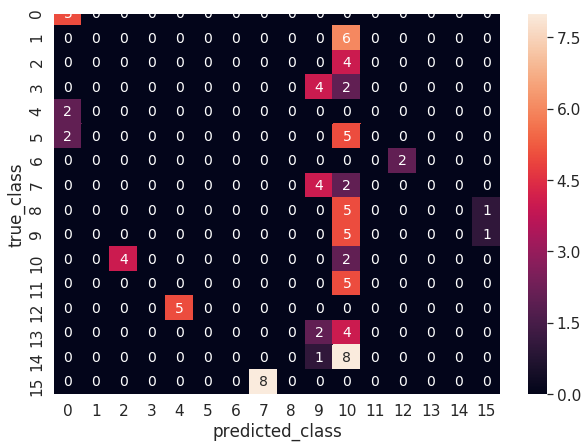

In [46]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(results, range(16),
                  range(16))
plt.figure(figsize = (10,7))
plt.tight_layout()
sn.set(font_scale=1.4)#for label size

ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 14},xticklabels=True, yticklabels=True)# font size
ax.set(xlabel='predicted_class', ylabel='true_class')
ax.set_ylim(16)
figure = ax.get_figure()    
# figure.savefig('2_sep_ax_conf.png', dpi=400)


In [26]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

Found 48 images belonging to 16 classes.
5/4 [===============================] - 0s 82ms/step
No of errors = 0/48
